<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [4]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [38]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('storage_sample_stage4-2.h5', 'train_df',mode='r')
df_final_test = read_hdf('storage_sample_stage4-2.h5', 'test_df',mode='r')

In [39]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [9]:
train_graph=nx.read_edgelist('train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)


def pref_followers(a,b):
    try:
        sim_ind=(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b))))
        return sim_ind
    except:
        return 0

df_final_train['pref_attach_followers']=df_final_train.apply(lambda row:pref_followers(row['source_node'],row['destination_node']),axis=1)
df_final_test['pref_attach_followers']=df_final_test.apply(lambda row:pref_followers(row['source_node'],row['destination_node']),axis=1)



  

In [36]:
print(df_final_train.head())

   jaccard_followers  jaccard_followees  cosine_followers  cosine_followees  \
0                  0           0.000000          0.000000          0.000000   
1                  0           0.187135          0.028382          0.343828   
2                  0           0.369565          0.156957          0.566038   
3                  0           0.000000          0.000000          0.000000   
4                  0           0.000000          0.000000          0.000000   

   num_followers_s  num_followees_s  num_followees_d  inter_followers  \
0                6               15                8                0   
1               94               61              142               11   
2               28               41               22               26   
3               11                5                7                0   
4                1               11                3                0   

   inter_followees  adar_index  ...     svd_v_s_6     svd_v_d_1     svd_v_d_2  \
0    

In [12]:
svs1=np.array(df_final_train['svd_u_s_1'])
svs2=np.array(df_final_train['svd_u_s_2'])
svs3=np.array(df_final_train['svd_u_s_3'])
svs4=np.array(df_final_train['svd_u_s_4'])
svs5=np.array(df_final_train['svd_u_s_5'])
svs6=np.array(df_final_train['svd_u_s_6'])
svs7=np.array(df_final_train['svd_v_s_1'])
svs8=np.array(df_final_train['svd_v_s_2'])
svs9=np.array(df_final_train['svd_v_s_3'])
svs10=np.array(df_final_train['svd_v_s_4'])
svs11=np.array(df_final_train['svd_v_s_5'])
svs12=np.array(df_final_train['svd_v_s_6'])
svd1=np.array(df_final_train['svd_u_d_1'])
svd2=np.array(df_final_train['svd_u_d_2'])
svd3=np.array(df_final_train['svd_u_d_3'])
svd4=np.array(df_final_train['svd_u_d_4'])
svd5=np.array(df_final_train['svd_u_d_5'])
svd6=np.array(df_final_train['svd_u_d_6'])
svd7=np.array(df_final_train['svd_u_d_1'])
svd8=np.array(df_final_train['svd_v_d_2'])
svd9=np.array(df_final_train['svd_v_d_3'])
svd10=np.array(df_final_train['svd_v_d_4'])
svd11=np.array(df_final_train['svd_v_d_5'])
svd12=np.array(df_final_train['svd_v_d_6'])
svudotfinal=[]
svddotfinal=[]
for i in range(len(svs1)):
    svs_udot=[]
    svd_udot=[]
    svs_vdot=[]
    svd_vdot=[]
    svs_udot.append(svs1[i])
    svs_udot.append(svs2[i])
    svs_udot.append(svs3[i])
    svs_udot.append(svs4[i])
    svs_udot.append(svs5[i])
    svs_udot.append(svs6[i])
    svs_vdot.append(svs7[i])
    svs_vdot.append(svs8[i])
    svs_vdot.append(svs9[i])
    svs_vdot.append(svs10[i])
    svs_vdot.append(svs11[i])
    svs_vdot.append(svs12[i])
    svd_udot.append(svd1[i])
    svd_udot.append(svd2[i])
    svd_udot.append(svd3[i])
    svd_udot.append(svd4[i])
    svd_udot.append(svd5[i])
    svd_udot.append(svd6[i])
    svd_vdot.append(svd7[i])
    svd_vdot.append(svd8[i])
    svd_vdot.append(svd9[i])
    svd_vdot.append(svd10[i])
    svd_vdot.append(svd11[i])
    svd_vdot.append(svd12[i])
    svudotfinal.append(np.dot(svs_udot,svd_udot))
    svddotfinal.append(np.dot(svs_vdot,svd_vdot))
df_final_train['SVS Dot Product U']=svudotfinal
df_final_train['SVS Dot Product V']=svddotfinal
print(df_final_train.head())

   source_node  destination_node  indicator_link  jaccard_followers  \
0       273084           1505602               1                  0   
1       832016           1543415               1                  0   
2      1325247            760242               1                  0   
3      1368400           1006992               1                  0   
4       140165           1708748               1                  0   

   jaccard_followees  cosine_followers  cosine_followees  num_followers_s  \
0           0.000000          0.000000          0.000000                6   
1           0.187135          0.028382          0.343828               94   
2           0.369565          0.156957          0.566038               28   
3           0.000000          0.000000          0.000000               11   
4           0.000000          0.000000          0.000000                1   

   num_followees_s  num_followees_d  ...     svd_v_s_6     svd_v_d_1  \
0               15                8  .

In [31]:
svs1=np.array(df_final_test['svd_u_s_1'])
svs2=np.array(df_final_test['svd_u_s_2'])
svs3=np.array(df_final_test['svd_u_s_3'])
svs4=np.array(df_final_test['svd_u_s_4'])
svs5=np.array(df_final_test['svd_u_s_5'])
svs6=np.array(df_final_test['svd_u_s_6'])
svs7=np.array(df_final_test['svd_v_s_1'])
svs8=np.array(df_final_test['svd_v_s_2'])
svs9=np.array(df_final_test['svd_v_s_3'])
svs10=np.array(df_final_test['svd_v_s_4'])
svs11=np.array(df_final_test['svd_v_s_5'])
svs12=np.array(df_final_test['svd_v_s_6'])
svd1=np.array(df_final_test['svd_u_d_1'])
svd2=np.array(df_final_test['svd_u_d_2'])
svd3=np.array(df_final_test['svd_u_d_3'])
svd4=np.array(df_final_test['svd_u_d_4'])
svd5=np.array(df_final_test['svd_u_d_5'])
svd6=np.array(df_final_test['svd_u_d_6'])
svd7=np.array(df_final_test['svd_u_d_1'])
svd8=np.array(df_final_test['svd_v_d_2'])
svd9=np.array(df_final_test['svd_v_d_3'])
svd10=np.array(df_final_test['svd_v_d_4'])
svd11=np.array(df_final_test['svd_v_d_5'])
svd12=np.array(df_final_test['svd_v_d_6'])
svudotfinal=[]
svddotfinal=[]
for i in range(len(svs1)):
    svs_udot=[]
    svs_vdot=[]
    svd_udot=[]
    svd_vdot=[]
    svs_udot.append(svs1[i])
    svs_udot.append(svs2[i])
    svs_udot.append(svs3[i])
    svs_udot.append(svs4[i])
    svs_udot.append(svs5[i])
    svs_udot.append(svs6[i])
    svs_vdot.append(svs7[i])
    svs_vdot.append(svs8[i])
    svs_vdot.append(svs9[i])
    svs_vdot.append(svs10[i])
    svs_vdot.append(svs11[i])
    svs_vdot.append(svs12[i])
    svd_udot.append(svd1[i])
    svd_udot.append(svd2[i])
    svd_udot.append(svd3[i])
    svd_udot.append(svd4[i])
    svd_udot.append(svd5[i])
    svd_udot.append(svd6[i])
    svd_vdot.append(svd7[i])
    svd_vdot.append(svd8[i])
    svd_vdot.append(svd9[i])
    svd_vdot.append(svd10[i])
    svd_vdot.append(svd11[i])
    svd_vdot.append(svd12[i])
    svudotfinal.append(np.dot(svs_udot,svd_udot))
    svddotfinal.append(np.dot(svs_vdot,svd_vdot))
df_final_test['SVS Dot Product U']=svudotfinal
df_final_test['SVS Dot Product V']=svddotfinal
print(df_final_test.head())

   jaccard_followers  jaccard_followees  cosine_followers  cosine_followees  \
0                  0                0.0          0.029161          0.000000   
1                  0                0.0          0.000000          0.000000   
2                  0                0.0          0.000000          0.000000   
3                  0                0.0          0.000000          0.000000   
4                  0                0.2          0.042767          0.347833   

   num_followers_s  num_followees_s  num_followees_d  inter_followers  \
0               14                6                9                1   
1               17                1               19                0   
2               10               16                9                0   
3               37               10               34                0   
4               27               15               27                4   

   inter_followees  adar_index  ...     svd_v_d_2     svd_v_d_3     svd_v_d_4  \
0    

In [40]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [41]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

Estimators =  10 Train Score 0.916031808979149 test Score 0.8984278994872664
Estimators =  50 Train Score 0.9181232750689972 test Score 0.9133901221098569
Estimators =  100 Train Score 0.9190342245877469 test Score 0.9140351245305189
Estimators =  250 Train Score 0.9209657880446134 test Score 0.9158243509625468
Estimators =  450 Train Score 0.9214206576499361 test Score 0.9165564582152528


Text(0.5,1,'Estimators vs score at depth of 5')

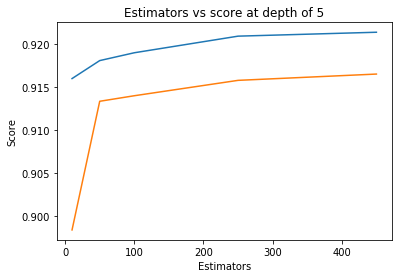

In [18]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.8785540082561737 test Score 0.8593592195457377
depth =  9 Train Score 0.9563841300308333 test Score 0.9230996309963099
depth =  11 Train Score 0.9592785970911829 test Score 0.9244532384701202
depth =  15 Train Score 0.9620183598282074 test Score 0.9248459785635919
depth =  20 Train Score 0.9621656815569143 test Score 0.9252837193604184
depth =  35 Train Score 0.9620175929221538 test Score 0.925071681565188
depth =  50 Train Score 0.9620175929221538 test Score 0.925071681565188
depth =  70 Train Score 0.9620175929221538 test Score 0.925071681565188
depth =  130 Train Score 0.9620175929221538 test Score 0.925071681565188


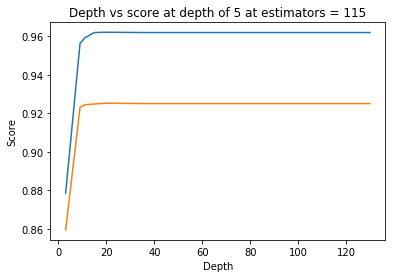

In [19]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [20]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25,return_train_score=True)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.96187661 0.96145871 0.95975427 0.96117622 0.96312084]
mean train scores [0.96275257 0.96229269 0.96033761 0.9618115  0.96401075]


In [21]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=14, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=28, min_samples_split=111,
                       min_weight_fraction_leaf=0.0, n_estimators=121,
                       n_jobs=-1, oob_score=False, random_state=25, verbose=0,
                       warm_start=False)


In [22]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [23]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [24]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9643208786300841
Test f1 score 0.9266136162687888


In [25]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


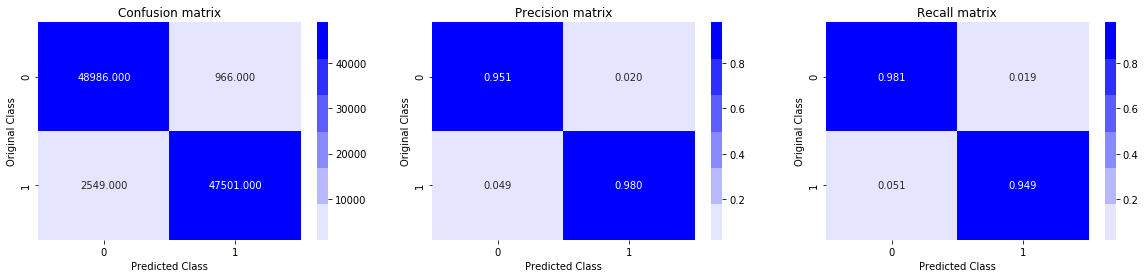

Test confusion_matrix


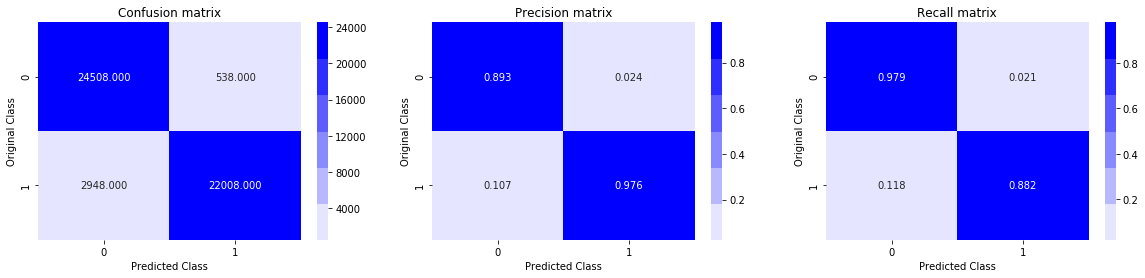

In [26]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

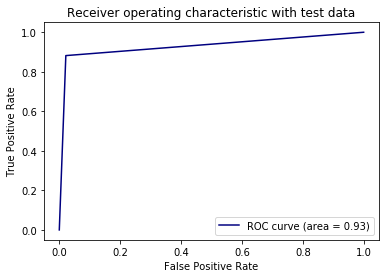

In [27]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

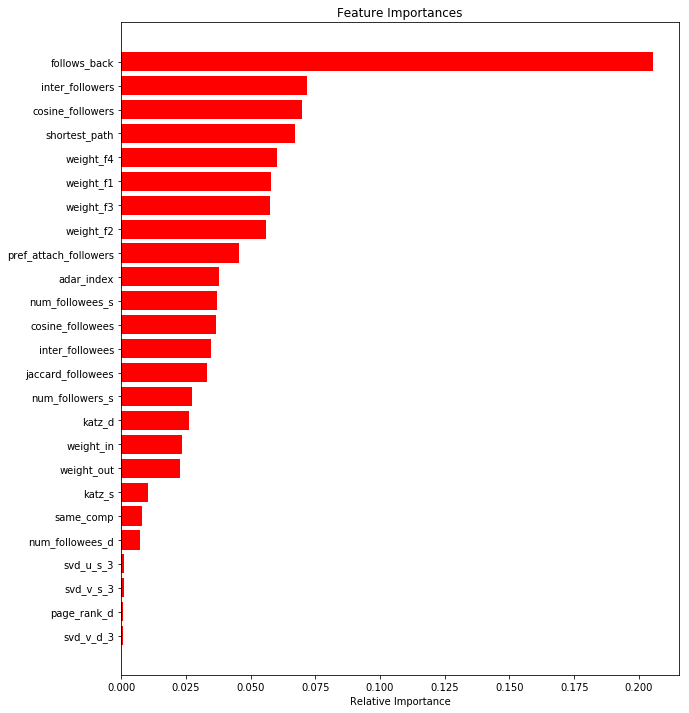

In [28]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [29]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

tuned_parameters={'n_estimators':[1,5,10,50],'max_depth':[1,5,10,50]}
model=RandomizedSearchCV(xgb.XGBClassifier(),tuned_parameters,scoring='neg_log_loss',cv=3,return_train_score=True)
model.fit(df_final_train,y_train)
print(model.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [42]:
from sklearn.metrics import log_loss
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'auc'
params['eta'] = 0.02
params['max_depth'] = 50
params['n_estimators']=50
d_train = xgb.DMatrix(df_final_train, label=y_train)
d_test = xgb.DMatrix(df_final_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(df_final_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-auc:0.998714	valid-auc:0.956642
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[10]	train-auc:0.999667	valid-auc:0.956789
[20]	train-auc:0.999771	valid-auc:0.956746
Stopping. Best iteration:
[6]	train-auc:0.999474	valid-auc:0.956864

The test log loss is: 0.4043140142481354


Exception ignored in: <bound method Booster.__del__ of <xgboost.core.Booster object at 0x1a4289d7f0>>
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/xgboost/core.py", line 957, in __del__
    if self.handle is not None:
AttributeError: 'Booster' object has no attribute 'handle'


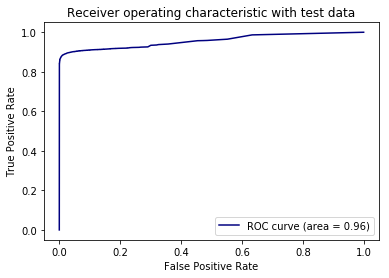

In [43]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,predict_y)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()